In [1]:
#bagging decision trees for classfication
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df_raw=pd.read_csv("./Data_Processed_All_Contractors_Characteristics - Data.csv")
df_raw.head(10)
df_raw.shape

(5046, 77)

In [3]:
column_list=list(df_raw.columns)
# print(column_list)

In [4]:
def find_index(name):
    index_num = column_list.index(name)
    print(index_num)

In [5]:
df_window_one_year = df_raw.loc[df_raw['applied_in_window_12months_or_not'] != 'Not enough info']
x_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1)
y_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,73].astype(int)
x_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1)
y_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,73].astype(int)



In [7]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
predict_results = clf.predict(x_test)

In [8]:
print(accuracy_score(predict_results, y_test))
conf_mat = confusion_matrix(y_test, predict_results)
print(conf_mat)

0.6605981794538361
[[ 46 250]
 [ 11 462]]


**Model Evaluation**

     1. Confusion Matrix
     2 TP, FP, TN, FN
     3. Accuracy Rate
     4. PPV & NPV
     5. Sensitivity & Specificity
     6. F1 Score
     7. Cumulative Gains Chart
     8. AUC-ROC Curve

In [9]:
from sklearn.metrics import confusion_matrix 
matrix = confusion_matrix(y_test.values, predict_results, labels=None, sample_weight=None)
def metrix_matrix(matrix):
    df_matrix=pd.DataFrame(matrix,columns=['pred_negative','pred_positive'],index=['actual_negative','actual_positive'])
    tn, fp, fn, tp=matrix.ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    summary_matrix=[acc,ppv,npv,tpr,tnr]
    df_summary=pd.DataFrame(summary_matrix,columns=['Value'],index=['Accuracy','PPV','NPV','Sensitivity','Specificity'])
    return df_matrix,df_summary

In [10]:
df_matrix,df_summary = metrix_matrix(matrix)
df_matrix

,pred_negative,pred_positive
actual_negative,46,250
actual_positive,11,462


In [12]:
df_summary

,Value
Accuracy,0.660598
PPV,0.648876
NPV,0.807018
Sensitivity,0.976744
Specificity,0.155405


In [13]:
pred_prob = clf.predict_proba(x_test)
df_pred_positive_prob=pd.DataFrame(pred_prob).drop(0,axis=1)
df_test_result=df_pred_positive_prob.rename(columns={1:'Predict_Positive_Prob'})
df_test_result['Predict']=predict_results
df_test_result['Actual']=y_test.tolist()
contractor_id = df_window_one_year.loc[(df_window_one_year['train_test'] == 0),'Dealer ID'].values
df_test_result['Contractor_ID']=contractor_id

#calculate true positive and its cumulative
df_test_result=df_test_result.sort_values(by=["Predict_Positive_Prob"],ascending=False).reset_index(drop=True)
df_test_result["True_Positive"]=df_test_result.apply(lambda x: ((x["Actual"]==x["Predict"]) & (x["Actual"]==1))*1,axis=1)
df_test_result["Cumulative_True_Positive"]=df_test_result["True_Positive"].cumsum() #numpy
total_true_positive=df_test_result["True_Positive"].sum()

#calculate % cumulative true positive counts vs % ID counts (linear)
df_test_result["%_Cumulative_True_Positive"]=df_test_result["Cumulative_True_Positive"]/total_true_positive
df_test_result["%_Cumulative_Count"]=df_test_result["Contractor_ID"].expanding().count()/df_test_result["Contractor_ID"].count() #.expanding(): pandas

df_test_result.head(10)

,Predict_Positive_Prob,Predict,Actual,Contractor_ID,True_Positive,Cumulative_True_Positive,%_Cumulative_True_Positive,%_Cumulative_Count
0,1.000000,1,1,C16956,1,1,0.002165,0.001300
1,1.000000,1,0,C16067,0,1,0.002165,0.002601
2,1.000000,1,0,A11087,0,1,0.002165,0.003901
3,0.911392,1,1,C17419,1,2,0.004329,0.005202
4,0.911392,1,1,C19119,1,3,0.006494,0.006502
5,0.911392,1,0,C18728,0,3,0.006494,0.007802
6,0.911392,1,1,C16530,1,4,0.008658,0.009103
7,0.911392,1,1,C18453,1,5,0.010823,0.010403
8,0.911392,1,1,C18822,1,6,0.012987,0.011704
9,0.911392,1,1,C18451,1,7,0.015152,0.013004


Text(0, 0.5, 'Cumulative % True Positives')

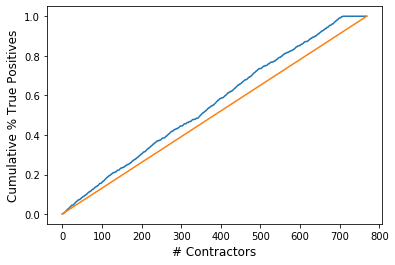

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df_test_result["%_Cumulative_True_Positive"].values.tolist())
plt.plot(df_test_result["%_Cumulative_Count"].values.tolist())
plt.xlabel('# Contractors',fontsize=12)
plt.ylabel('Cumulative % True Positives',fontsize=12)

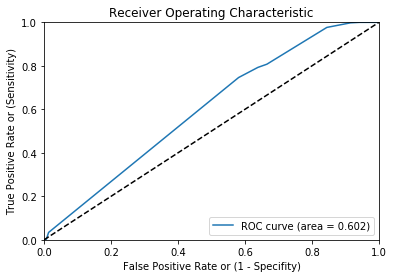

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


fpr, tpr, thresholds = roc_curve(df_test_result["Actual"].values.tolist(), df_test_result["Predict_Positive_Prob"].values.tolist())
roc_auc = auc(fpr,tpr)


plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")